# isoformsFromFLAIR.ipynb
## Marcus Viscardi,    January 21, 2023

So on Friday Jan 20th, I reran the pipelines for all four new libs and the two pilot libraries with the tag for FLAIR analysis turned on. Here I want to try and dig into those FLAIR outputs and see if I can pick out any isoform dependent effects such as NMD-sensitivity, or tail length differences!

Large detail here. FLAIR adds a transcript_id tag, but this doesn't necessarily match the gene_id tag carried over from featureCounts (I *think*). This means I'll need to add a step to "back calculate" the gene_id/_name

In [6]:
import os
import pandas as pd
import numpy as np
import seaborn as sea
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import product
from pathlib import Path
import sys
sys.path.insert(0, '/data16/marcus/scripts/nanoporePipelineScripts')
import nanoporePipelineCommon as npCommon
from nanoporeReadPlotting.finalizingReadAndCoveragePlotting_matplotlib import plot_reads, coverage_plotting_5tera

CONVERSION_DICT = {"xrn-1-5tera": "oldN2",
                   "xrn-1-5tera-smg-6": "oldS6",
                   "5tera_xrn-1-KD_wt": "newN2",
                   "5tera_xrn-1-KD_smg-5": "newS5",
                   "5tera_xrn-1-KD_smg-6": "newS6",
                   "5tera_xrn-1-KD_smg-7": "newS7",
                   "5tera_xrn-1-KD_wt_rerun": "newerN2",
                   "sPM57": "sPM57",
                   "sPM58": "sPM58",
                   }
REV_CONVERSION_DICT = {val: key for key, val in CONVERSION_DICT.items()}

from typing import List

def load_flair_and_filter_assignments_with_genes(target_lib_name: str,
                                                 trust_flair_assignment=True) -> pd.DataFrame:
    # Load the transcripts tsv and the genes parquet:
    lib_txns_df = npCommon.adjust_5_ends(pd.read_table(npCommon.pick_lib_return_path(target_lib_name, file_midfix='_mergedWithTranscripts', file_suffix='.tsv'))).set_index('read_id')
    lib_genes_df = npCommon.adjust_5_ends(pd.read_parquet(npCommon.pick_lib_return_path(target_lib_name, file_midfix='_mergedOnReads', file_suffix='.parquet'))).set_index('read_id')
    # Also load my pre-parsed gtf file which will allow us to convert the FLAIR transcript_id to gene_ids/_names/_biotypes!
    gtf_df = pd.read_parquet("/data16/marcus/genomes/elegansRelease100/Caenorhabditis_elegans.WBcel235.100.gtf.parquet")[['chr', 'feature', 'gene_id', 'gene_name', 'gene_biotype', 'transcript_id', 'transcript_biotype']]
    gtf_df = gtf_df.query("feature == 'transcript'")[['transcript_id', 'gene_id', 'gene_name', 'gene_biotype', 'transcript_biotype']]
    # Merge those:
    lib_txns_df = lib_txns_df.reset_index().merge(gtf_df, on='transcript_id', how='left',
                                                  suffixes=('_original', ''))
    
    # Merge the FLAIR dataframe and the gene assignment info from the gene dataframe:
    lib_txns_extended_df = pd.merge(lib_txns_df,
                                    lib_genes_df[['gene_id', 'gene_name', 'chr', 'chr_pos']].reset_index(),
                                    on=['read_id', 'chr', 'chr_pos'],
                                    # inner vs. outer here really just changes whether on not we carry over all the reads that made it through to the gene table but not the transcript table!
                                    how='left',
                                    suffixes=('', '_fromGeneAssign')).set_index('read_id')
    
    # Perform the filtering for matched assignment between both methods. This is conservative, but at least it avoids issues arising from FLAIR not giving us enough info to figure out which read on multimappers we are looking at!
    if trust_flair_assignment:
        print(f"We are trusting the flair assignment despite {lib_txns_extended_df[lib_txns_extended_df.gene_id != lib_txns_extended_df.gene_id_fromGeneAssign].shape[0]} genes not matching with gene assignment!")
    else:
        read_count_before_filter = lib_txns_extended_df.shape[0]
        lib_txns_extended_df = lib_txns_extended_df[lib_txns_extended_df.gene_id == lib_txns_extended_df.gene_id_fromGeneAssign]
        read_count_after_filter = lib_txns_extended_df.shape[0]
        reads_lost = read_count_before_filter - read_count_after_filter
        print(f"After filtering for reads where both FLAIR and geneAssign/featureCount assignments match, {read_count_after_filter:,} of {read_count_before_filter:,} reads remain.\n"
              f"This is a loss of {reads_lost:,} reads, or {reads_lost / read_count_before_filter:0.2%}")
    lib_txns_extended_df['lib'] = CONVERSION_DICT[target_lib_name]
    return  lib_txns_extended_df.reset_index()


def long_to_wide(input_df, wide_target_cols=['gene_rpm'], expand_col='lib') -> pd.DataFrame:
    w = input_df[wide_target_cols].unstack(level=expand_col)
    w.columns = w.columns.map('{0[0]}_{0[1]}'.format)
    return w.reset_index().fillna(0)

def compress_df(input_df, keep_transcript_info=True, group_by_t5=True, additional_groupby_columns: List[str] = None, calc_protein_coding_rpm=True):
    groupby_col_list = ["lib",
                        "chr_id",
                        "gene_id",
                        "gene_name"]
    print(f"Creating groupby dataframe merged on: {groupby_col_list}")
    if keep_transcript_info:
        print(f"\t+ [transcript_id]")
        groupby_col_list.append("transcript_id")
    if group_by_t5:
        print(f"\t+ [t5] tag")
        groupby_col_list.append("t5")
    if additional_groupby_columns:
        for additional_col in additional_groupby_columns:
            print(f"\t+ [{additional_col}]")
            groupby_col_list.append(additional_col)
    # Holy crap, the observed=True helps to keep this from propagating out to 129,151,669,691,968 rows...
    groupby_obj = input_df.groupby(groupby_col_list, observed=True)
    # Change the compressed prefix so that I am count gene hits or transcript hits, depending on set up!
    if not keep_transcript_info:
        compressed_prefix = "gene"
    else:
        compressed_prefix = "transcript"
    tqdm.pandas(desc=f"Counting reads per {compressed_prefix}")
    compressed_df = groupby_obj["read_id"].progress_apply(len).to_frame(name=f"{compressed_prefix}_hits")
    
    compressed_df["mean_polya_length"] = groupby_obj["polya_length"].mean()
    compressed_df["median_polya_length"] = groupby_obj["polya_length"].median()
    compressed_df["called_polya_count"] = groupby_obj["polya_length"].count()
    compressed_df["called_polya_frac"] = compressed_df["called_polya_count"] / compressed_df[f"{compressed_prefix}_hits"]
    
    compressed_df["mean_read_length"] = groupby_obj["read_length"].mean()
    compressed_df["median_read_length"] = groupby_obj["read_length"].median()
    # RPM and fractional hits calculations
    # Need to first create columns of NA values, tobe overwritten
    compressed_df[f"{compressed_prefix}_rpm"] = pd.NA
    compressed_df[f"{compressed_prefix}_frac_hits"] = pd.NA
    if group_by_t5:
        compressed_df[f"{compressed_prefix}_t5group_rpm"] = pd.NA
    if calc_protein_coding_rpm:
        compressed_df[f"{compressed_prefix}_proteinCoding_rpm"] = pd.NA
        gene_id_and_biotype_df = pd.read_parquet("/data16/marcus/genomes/elegansRelease100/Caenorhabditis_elegans.WBcel235.100.gtf.parquet")[['gene_id', 'gene_biotype']].drop_duplicates()
        compressed_df = compressed_df.reset_index().merge(gene_id_and_biotype_df, on='gene_id', how='left').set_index(compressed_df.index.names)
    # Only look at one library at a time (so the normalization is per lib not whole df)
    for lib in compressed_df.index.unique(level='lib').to_list():
        # Create the 'norm_factor' which will be the total # of read hits in that lib
        norm_factor = compressed_df.query(f"lib == '{lib}'")[f"{compressed_prefix}_hits"].sum()
        # Turn the total number of read hits into the 'million of read hits'
        rpm_norm_factor = norm_factor / 1000000
        # For each library divide gene_hits by the rpm norm factor to get rpm
        rpm_series = compressed_df.query(f"lib == '{lib}'")[f"{compressed_prefix}_hits"] / rpm_norm_factor
        # Use a series fill, so that we can fill that library's part of the DF without effecting others
        compressed_df[f"{compressed_prefix}_rpm"] = compressed_df[f"{compressed_prefix}_rpm"]. \
            fillna(value=rpm_series)
        # Same as above, but with fraction of hits, rather than a rpm calc (practically same thing)
        gene_frac_hits_series = compressed_df.query(f"lib == '{lib}'")[f"{compressed_prefix}_hits"] / norm_factor
        compressed_df[f"{compressed_prefix}_frac_hits"] = compressed_df[f"{compressed_prefix}_frac_hits"]. \
            fillna(value=gene_frac_hits_series)
        if group_by_t5:
            # We can also calculate an adapted-specific RPM:
            for adapted_or_not in ["+", "-"]:
                norm_factor = compressed_df.query(f"lib == '{lib}'")\
                    .query(f"t5 == '{adapted_or_not}'")[f"{compressed_prefix}_hits"].sum()
                rpm_norm_factor = norm_factor / 1_000_000
                rpm_series = compressed_df.query(f"lib == '{lib}'")\
                    .query(f"t5 == '{adapted_or_not}'")[f"{compressed_prefix}_hits"] / rpm_norm_factor
                compressed_df[f"{compressed_prefix}_t5group_rpm"] = compressed_df[
                    f"{compressed_prefix}_t5group_rpm"].fillna(value=rpm_series, axis='index')
        if calc_protein_coding_rpm:
            protein_coding_norm_factor = compressed_df.query(f"lib == '{lib}'").query(f"gene_biotype == 'protein_coding'")[f"{compressed_prefix}_hits"].sum()
            protein_coding_rpm_norm_factor = protein_coding_norm_factor / 1000000
            protein_coding_rpm_series = compressed_df.query(f"lib == '{lib}'")[f"{compressed_prefix}_hits"] / protein_coding_rpm_norm_factor
            compressed_df[f"{compressed_prefix}_proteinCoding_rpm"] = compressed_df[f"{compressed_prefix}_proteinCoding_rpm"]. \
                fillna(value=protein_coding_rpm_series)
    return compressed_df

print(f"Imports done at {npCommon.get_dt(for_print=True)}")

Imports done at 03/27/23 @ 04:24:04 PM


# First lets check to see if my usual method and the FLAIR method at least assigned things to the same genes!

The detail here is that I need to reverse look up the gene_id from the transcript_id that FLAIR provided!!

So, messing around with the FLAIR dataframe has helped me realize/remember an issue. The FLAIR outputs only spit out read_id and transcript_id (at least in the way that I hacked it together). This means that any multimapping reads will have no means to resolve which assignment went with which map! This isn't a large scale issue at the moment, in this case (newN2) I can see 76.5k reads that match gene_ids from gene analysis and FLAIR, but ~18.3k are assigned by FLAIR but not my method, another ~500 reads are explicitly mismatched between the methods. I can toss everything besides the 76.5k out of 95.3k reads

For now, we will go with the conservative method, throw out everything that doesn't perfectly match. Maybe I'll have this spit out a percentage lost when doing this for my records.

## Load libs:

If there isn't an avaible preprocessed file, this lib loading step will take a little.

In [3]:
regenerate = False
libs_to_load = sorted({
    "oldN2",
    # "oldS6",
    "newN2",
    # "newS5",
    # "newS6",
    # "newS7",
    "sPM57",
    "sPM58",
    "newerN2"
    })
try:
    if regenerate:
        raise ValueError
    
    reads_df_raw_path = npCommon.find_newest_matching_file(f"./output_files/*_{'-'.join(libs_to_load)}_5TERA.reads_df.transcripts.parquet")
    txn_df_raw_path = npCommon.find_newest_matching_file(f"./output_files/*_{'-'.join(libs_to_load)}_5TERA.compressed_df.transcripts.parquet")
    print(f"Found preprocessed files at:\n\t{reads_df_raw_path}\nand:\n\t{txn_df_raw_path}")
    
    txn_df_raw = pd.read_parquet(txn_df_raw_path)
    reads_df_raw = pd.read_parquet(reads_df_raw_path)
except ValueError:
    print(f"Could not find preprocessed files matching these libs: {'/'.join(libs_to_load)}\nGoing to create new ones from scratch! This will take longer.")
    lib_dict = {}
    for lib in libs_to_load:
        lib_dict[lib] = load_flair_and_filter_assignments_with_genes(REV_CONVERSION_DICT[lib])
    
    reads_df_raw = pd.concat(list(lib_dict.values()))
    
    txn_df_raw = compress_df(reads_df_raw, keep_transcript_info=True).sort_index(level=['lib',
                                                                                        'chr_id',
                                                                                        'gene_id',
                                                                                        'gene_name',
                                                                                        'transcript_id'])
    print(f"Saving new parquets to speed up future runs.")
    reads_df_raw.to_parquet(f"./output_files/{npCommon.get_dt()}_{'-'.join(libs_to_load)}_5TERA.reads_df.transcripts.parquet")
    txn_df_raw.to_parquet(f"./output_files/{npCommon.get_dt()}_{'-'.join(libs_to_load)}_5TERA.compressed_df.transcripts.parquet")
print(f"Lib load done @ {npCommon.get_dt(for_print=True)}")

Could not find preprocessed files matching these libs: newN2/newerN2/oldN2/sPM57/sPM58
Going to create new ones from scratch! This will take longer.
Looking for file for 5tera_xrn-1-KD_wt, at /data16/marcus/working/221216_nanoporeRun_totalRNA_wt_xrn-1-KD_5TERA/output_dir/merge_files/*_mergedWithTranscripts.tsv... File Found.

Making adjustments for 5' ends:


100%|██████████| 95308/95308 [00:01<00:00, 79020.52it/s]


Looking for file for 5tera_xrn-1-KD_wt, at /data16/marcus/working/221216_nanoporeRun_totalRNA_wt_xrn-1-KD_5TERA/output_dir/merge_files/*_mergedOnReads.parquet... File Found.

Making adjustments for 5' ends:


100%|██████████| 134042/134042 [00:01<00:00, 74912.77it/s]


We are trusting the flair assignment despite 18771 genes not matching with gene assignment!
Looking for file for 5tera_xrn-1-KD_wt_rerun, at /data16/marcus/working/230327_nanoporeRun_totalRNA_wt_xrn-1-KD_5TERA_rerun/output_dir/merge_files/*_mergedWithTranscripts.tsv... File Found.

Making adjustments for 5' ends:


100%|██████████| 443893/443893 [00:06<00:00, 67494.05it/s]


Looking for file for 5tera_xrn-1-KD_wt_rerun, at /data16/marcus/working/230327_nanoporeRun_totalRNA_wt_xrn-1-KD_5TERA_rerun/output_dir/merge_files/*_mergedOnReads.parquet... File Found.

Making adjustments for 5' ends:


100%|██████████| 1053185/1053185 [00:12<00:00, 81880.61it/s] 


We are trusting the flair assignment despite 84491 genes not matching with gene assignment!
Looking for file for xrn-1-5tera, at /data16/marcus/working/211118_nanoporeRun_totalRNA_5108_xrn-1-KD_5TERA/output_dir/merge_files/*_mergedWithTranscripts.tsv... File Found.

Making adjustments for 5' ends:


100%|██████████| 534178/534178 [00:09<00:00, 59305.71it/s]


Looking for file for xrn-1-5tera, at /data16/marcus/working/211118_nanoporeRun_totalRNA_5108_xrn-1-KD_5TERA/output_dir/merge_files/*_mergedOnReads.parquet... File Found.

Making adjustments for 5' ends:


100%|██████████| 701680/701680 [00:11<00:00, 59576.07it/s] 


We are trusting the flair assignment despite 105614 genes not matching with gene assignment!
Looking for file for sPM57, at /data16/marcus/working/230130_nanoporeRun_totalRNA_sPM57_xrn-1-KD_5PTERA/output_dir/merge_files/*_mergedWithTranscripts.tsv... File Found.

Making adjustments for 5' ends:


100%|██████████| 936642/936642 [00:13<00:00, 68188.69it/s] 


Looking for file for sPM57, at /data16/marcus/working/230130_nanoporeRun_totalRNA_sPM57_xrn-1-KD_5PTERA/output_dir/merge_files/*_mergedOnReads.parquet... File Found.

Making adjustments for 5' ends:


100%|██████████| 1251560/1251560 [00:19<00:00, 63418.65it/s]


We are trusting the flair assignment despite 176460 genes not matching with gene assignment!
Looking for file for sPM58, at /data16/marcus/working/230207_nanoporeRun_totalRNA_sPM58_xrn-1-KD_5PTERA/output_dir/merge_files/*_mergedWithTranscripts.tsv... File Found.

Making adjustments for 5' ends:


100%|██████████| 526479/526479 [00:07<00:00, 75003.97it/s] 


Looking for file for sPM58, at /data16/marcus/working/230207_nanoporeRun_totalRNA_sPM58_xrn-1-KD_5PTERA/output_dir/merge_files/*_mergedOnReads.parquet... File Found.

Making adjustments for 5' ends:


100%|██████████| 743277/743277 [00:10<00:00, 73670.10it/s] 


We are trusting the flair assignment despite 89043 genes not matching with gene assignment!
Creating groupby dataframe merged on: ['lib', 'chr_id', 'gene_id', 'gene_name']
	+ [transcript_id]
	+ [t5] tag


Counting reads per transcript: 100%|██████████| 95208/95208 [00:01<00:00, 57708.09it/s]


Saving new parquets to speed up future runs.
Lib load done @ 03/27/23 @ 04:22:09 PM


In [26]:
old_df_raw = reads_df_raw[reads_df_raw.lib.str.startswith('old')].copy()

new_df_raw = reads_df_raw[reads_df_raw.lib.str.startswith('new')].copy()

sPM_df_raw = reads_df_raw[reads_df_raw.lib.str.startswith('sPM')].copy()


old_txn_df = compress_df(old_df_raw, keep_transcript_info=True).sort_index(level=['lib', 'chr_id', 'gene_id', 'gene_name', 'transcript_id'])
old_gene_df = compress_df(old_df_raw, keep_transcript_info=False).sort_index(level=['lib', 'chr_id', 'gene_id', 'gene_name'])

new_txn_df = compress_df(new_df_raw, keep_transcript_info=True).sort_index(level=['lib', 'chr_id', 'gene_id', 'gene_name', 'transcript_id'])
new_gene_df = compress_df(new_df_raw, keep_transcript_info=False).sort_index(level=['lib', 'chr_id', 'gene_id', 'gene_name'])

sPM_txn_df = compress_df(sPM_df_raw, keep_transcript_info=True).sort_index(level=['lib', 'chr_id', 'gene_id', 'gene_name', 'transcript_id'])
sPM_gene_df = compress_df(sPM_df_raw, keep_transcript_info=False).sort_index(level=['lib', 'chr_id', 'gene_id', 'gene_name'])

Creating groupby dataframe merged on: ['lib', 'chr_id', 'gene_id', 'gene_name']
	+ [transcript_id]
	+ [t5] tag


Counting reads per transcript: 100%|██████████| 23185/23185 [00:00<00:00, 47698.20it/s]


Creating groupby dataframe merged on: ['lib', 'chr_id', 'gene_id', 'gene_name']
	+ [t5] tag


Counting reads per gene: 100%|██████████| 20811/20811 [00:00<00:00, 63946.44it/s]


Creating groupby dataframe merged on: ['lib', 'chr_id', 'gene_id', 'gene_name']
	+ [transcript_id]
	+ [t5] tag


Counting reads per transcript: 100%|██████████| 30732/30732 [00:00<00:00, 62320.28it/s]


Creating groupby dataframe merged on: ['lib', 'chr_id', 'gene_id', 'gene_name']
	+ [t5] tag


Counting reads per gene: 100%|██████████| 28496/28496 [00:00<00:00, 53335.73it/s]


Creating groupby dataframe merged on: ['lib', 'chr_id', 'gene_id', 'gene_name']
	+ [transcript_id]
	+ [t5] tag


Counting reads per transcript: 100%|██████████| 41291/41291 [00:00<00:00, 49983.72it/s]


Creating groupby dataframe merged on: ['lib', 'chr_id', 'gene_id', 'gene_name']
	+ [t5] tag


Counting reads per gene: 100%|██████████| 37657/37657 [00:00<00:00, 57785.11it/s]


# Reproducibility check:

In [116]:
col_targets = ['gene_rpm', 'mean_polya_length', 'gene_hits', 'mean_read_length', 'gene_proteinCoding_rpm']
new_wide_df = long_to_wide(new_gene_df, wide_target_cols=col_targets).sort_values('gene_rpm_newN2', ascending=False)
triple_wide_df_raw = new_wide_df.merge(long_to_wide(old_gene_df, wide_target_cols=col_targets), on=['chr_id', 'gene_id', 'gene_name', 't5'])
super_wide_df_raw = triple_wide_df_raw.merge(long_to_wide(sPM_gene_df, wide_target_cols=col_targets), on=['chr_id', 'gene_id', 'gene_name', 't5'])
print(new_gene_df.columns)
print(super_wide_df_raw.columns)

Index(['gene_hits', 'mean_polya_length', 'median_polya_length', 'called_polya_count',
       'called_polya_frac', 'mean_read_length', 'median_read_length', 'gene_rpm', 'gene_frac_hits',
       'gene_t5group_rpm', 'gene_proteinCoding_rpm', 'gene_biotype'],
      dtype='object')
Index(['chr_id', 'gene_id', 'gene_name', 't5', 'gene_rpm_newN2', 'gene_rpm_newerN2',
       'mean_polya_length_newN2', 'mean_polya_length_newerN2', 'gene_hits_newN2',
       'gene_hits_newerN2', 'mean_read_length_newN2', 'mean_read_length_newerN2',
       'gene_proteinCoding_rpm_newN2', 'gene_proteinCoding_rpm_newerN2', 'gene_rpm_oldN2',
       'mean_polya_length_oldN2', 'gene_hits_oldN2', 'mean_read_length_oldN2',
       'gene_proteinCoding_rpm_oldN2', 'gene_rpm_sPM57', 'gene_rpm_sPM58',
       'mean_polya_length_sPM57', 'mean_polya_length_sPM58', 'gene_hits_sPM57', 'gene_hits_sPM58',
       'mean_read_length_sPM57', 'mean_read_length_sPM58', 'gene_proteinCoding_rpm_sPM57',
       'gene_proteinCoding_rpm_sPM58']

/tmp/ipykernel_3175382/1159637245.py:60: MatplotlibDeprecationWarning:

The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.

/tmp/ipykernel_3175382/1159637245.py:61: MatplotlibDeprecationWarning:

The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.



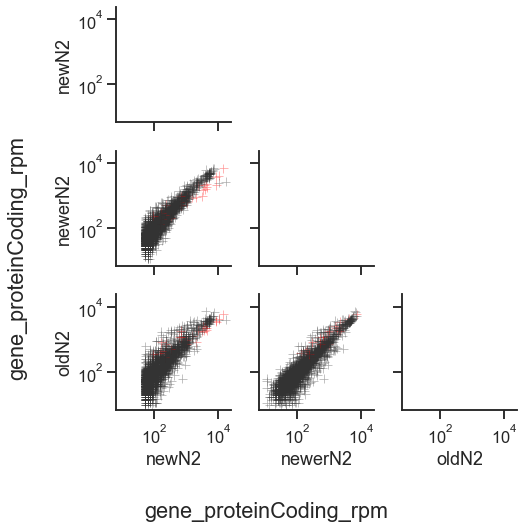

In [196]:
super_wide_df = super_wide_df_raw.copy(deep=True)
triple_wide_df = triple_wide_df_raw.copy(deep=True)

cutoff = 5
prefix_target = "gene_hits"
for lib in ["oldN2", "newN2", "newerN2", "sPM57", "sPM58"]:
    super_wide_df = super_wide_df.query(f"{prefix_target}_{lib} >= {cutoff}")
    if lib.endswith("N2"):
        triple_wide_df = triple_wide_df.query(f"{prefix_target}_{lib} >= {cutoff}")
super_wide_df['is_MtDNA'] = super_wide_df_raw['chr_id'] == 'MtDNA'


sea.set_style('ticks')
sea.set_context('talk')

prefix_to_plot = "gene_proteinCoding_rpm"  # "mean_read_length" #  "gene_rpm" # "mean_polya_length"  # "gene_proteinCoding_rpm"

cols_to_plot = [col for col in triple_wide_df.columns if col.startswith(prefix_to_plot)]
g = sea.PairGrid(super_wide_df,
                 vars=cols_to_plot,
                 diag_sharey=True,
                 corner=True,
                 hue='is_MtDNA',
                 palette=['0.2', 'r'],
                 )
if prefix_to_plot in ('gene_rpm', 'gene_proteinCoding_rpm'):
    g.set(xscale='log',
          yscale='log',
          )
# else:
#     g.set(xscale='log',
#       yscale='log',
#       )
# g.map_diag(sea.ecdfplot,
#            # sea.kdeplot,
#            # color='0.2',
#            )
g.map_lower(sea.scatterplot,
            alpha=0.4, marker='+',
            # color='0.2',
            )
# g.map_upper(sea.histplot,
#             # color='0.0',
#             )

g.figure.supxlabel(prefix_to_plot)
g.figure.supylabel(prefix_to_plot)
###
# Get axis labels for each subplot
real_axes=[]
for ax in g.axes.flat:
    if ax:
        real_axes.append(ax)
        x_label = ax.get_xlabel()
        if x_label:
            ax.set_xlabel(x_label.rsplit('_')[-1])
        y_label = ax.get_ylabel()
        if y_label:
            ax.set_ylabel(y_label.rsplit('_')[-1])
real_axes[-1].get_shared_x_axes().join(*real_axes)
real_axes[-1].get_shared_y_axes().join(*real_axes)
xlims = real_axes[-1].get_xlim()
ylims = real_axes[-1].get_ylim()
min_lim = min(xlims[0], ylims[0])
max_lim = max(xlims[1], ylims[1])
real_axes[-1].set_xlim(min_lim, max_lim)
real_axes[-1].set_ylim(min_lim, max_lim)
###
plt.tight_layout()

save_dir = f"/home/marcus/Insync/marcus.viscardi@gmail.com/Google Drive" \
           f"/insync_folder/5TERA_ReadsAndTails_Plots/raw_figures_from_python" \
           f"/{npCommon.get_dt()}_N2_reproducibility"
save_dir = Path(save_dir)
save_dir.mkdir(exist_ok=True)
save_path = save_dir / f'scatterMatrix_{prefix_to_plot}'
for file_type in ('.svg', '.png'):
    plt.savefig(str(save_path) + file_type,
                # dpi=150,
                )
plt.show()

# Rewrite of barplot script:

This is just an effort to rewrite some old code in a less verbose way! Took some effort but works great!

The down-side here is that the gene level plots are actually only showing reads that successfully had their isoforms identified. There are a good number of reads that were unable to assign isoforms because their ambiguous, but they still were obviously the target gene!!

Creating groupby dataframe merged on: ['lib', 'chr_id', 'gene_id', 'gene_name']
	+ [t5] tag


Counting reads per gene: 100%|██████████| 33614/33614 [00:00<00:00, 63372.19it/s]


['oldN2', 'oldN2', 'oldN2', 'oldS6']
Creating groupby dataframe merged on: ['lib', 'chr_id', 'gene_id', 'gene_name']
	+ [t5] tag
	+ [NMD Sensitive Isoform]


Counting reads per gene: 100%|██████████| 33616/33616 [00:00<00:00, 54218.95it/s]


['oldN2_False', 'oldN2_False', 'oldN2_False', 'oldN2_True', 'oldS6_False', 'oldS6_True']
Creating groupby dataframe merged on: ['lib', 'chr_id', 'gene_id', 'gene_name']
	+ [t5] tag


Counting reads per gene: 100%|██████████| 39452/39452 [00:00<00:00, 60143.82it/s]


['newN2', 'newS5', 'newS6', 'newS7']
Creating groupby dataframe merged on: ['lib', 'chr_id', 'gene_id', 'gene_name']
	+ [t5] tag
	+ [NMD Sensitive Isoform]


Counting reads per gene: 100%|██████████| 39458/39458 [00:00<00:00, 66948.04it/s]


['newN2_False', 'newN2_True', 'newS5_False', 'newS5_True', 'newS6_False', 'newS6_True', 'newS7_False', 'newS7_True']


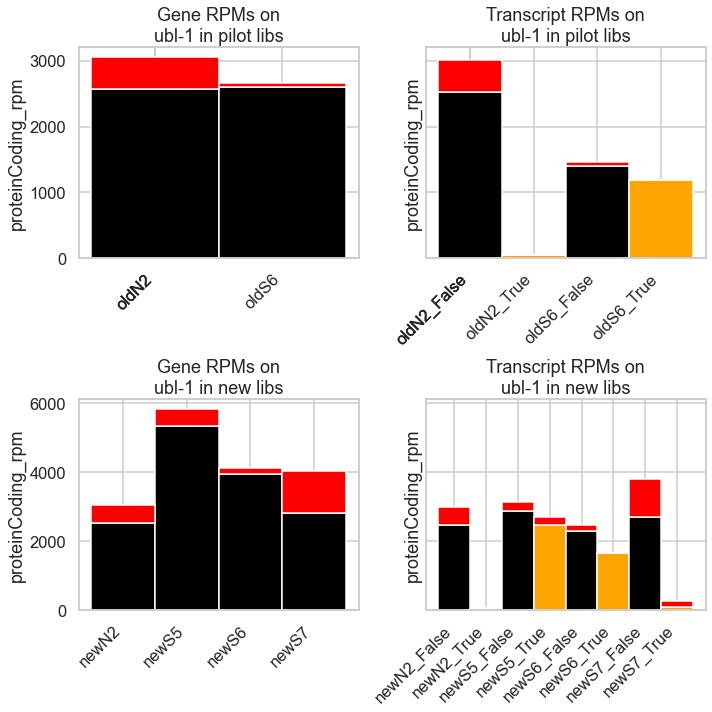

Creating groupby dataframe merged on: ['lib', 'chr_id', 'gene_id', 'gene_name']
	+ [t5] tag


Counting reads per gene: 100%|██████████| 33614/33614 [00:00<00:00, 55504.68it/s]


['oldN2', 'oldN2', 'oldS6']
Creating groupby dataframe merged on: ['lib', 'chr_id', 'gene_id', 'gene_name']
	+ [t5] tag
	+ [NMD Sensitive Isoform]


Counting reads per gene: 100%|██████████| 33617/33617 [00:00<00:00, 53800.93it/s]


['oldN2_False', 'oldN2_False', 'oldN2_True', 'oldS6_False', 'oldS6_True']
Creating groupby dataframe merged on: ['lib', 'chr_id', 'gene_id', 'gene_name']
	+ [t5] tag


Counting reads per gene: 100%|██████████| 39452/39452 [00:00<00:00, 67804.66it/s]


['newN2', 'newS5', 'newS6', 'newS7']
Creating groupby dataframe merged on: ['lib', 'chr_id', 'gene_id', 'gene_name']
	+ [t5] tag
	+ [NMD Sensitive Isoform]


Counting reads per gene: 100%|██████████| 39456/39456 [00:00<00:00, 56954.81it/s]


['newN2_False', 'newN2_True', 'newS5_False', 'newS5_True', 'newS6_False', 'newS6_True', 'newS7_False', 'newS7_True']


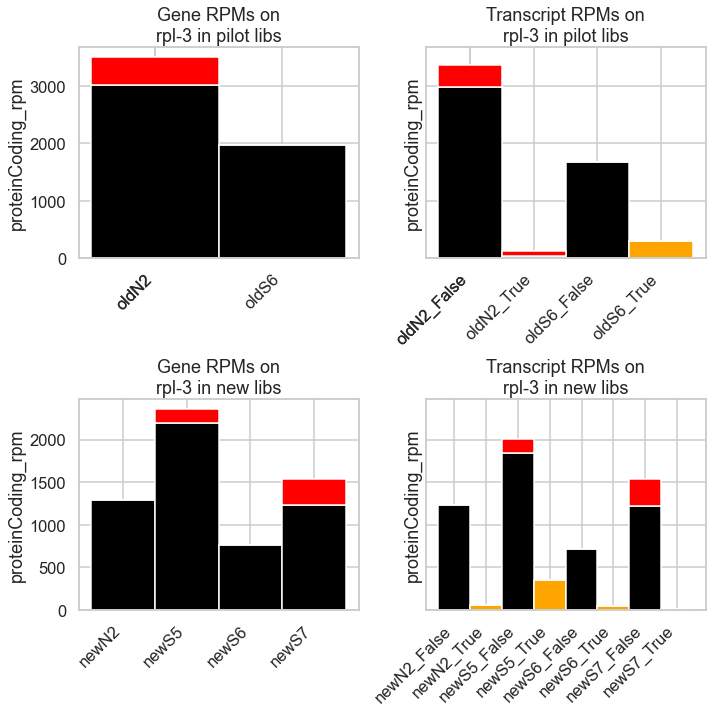

Creating groupby dataframe merged on: ['lib', 'chr_id', 'gene_id', 'gene_name']
	+ [t5] tag


Counting reads per gene: 100%|██████████| 33614/33614 [00:00<00:00, 54786.41it/s]


['oldN2', 'oldN2', 'oldN2', 'oldS6']
Creating groupby dataframe merged on: ['lib', 'chr_id', 'gene_id', 'gene_name']
	+ [t5] tag
	+ [NMD Sensitive Isoform]


Counting reads per gene: 100%|██████████| 33614/33614 [00:00<00:00, 62758.08it/s]


['oldN2_True', 'oldN2_True', 'oldN2_True', 'oldS6_True']
Creating groupby dataframe merged on: ['lib', 'chr_id', 'gene_id', 'gene_name']
	+ [t5] tag


Counting reads per gene: 100%|██████████| 39452/39452 [00:00<00:00, 57958.97it/s]


['newN2', 'newS5', 'newS5', 'newS6', 'newS7']
Creating groupby dataframe merged on: ['lib', 'chr_id', 'gene_id', 'gene_name']
	+ [t5] tag
	+ [NMD Sensitive Isoform]


Counting reads per gene: 100%|██████████| 39452/39452 [00:00<00:00, 65942.16it/s]


['newN2_True', 'newS5_True', 'newS5_True', 'newS6_True', 'newS7_True']


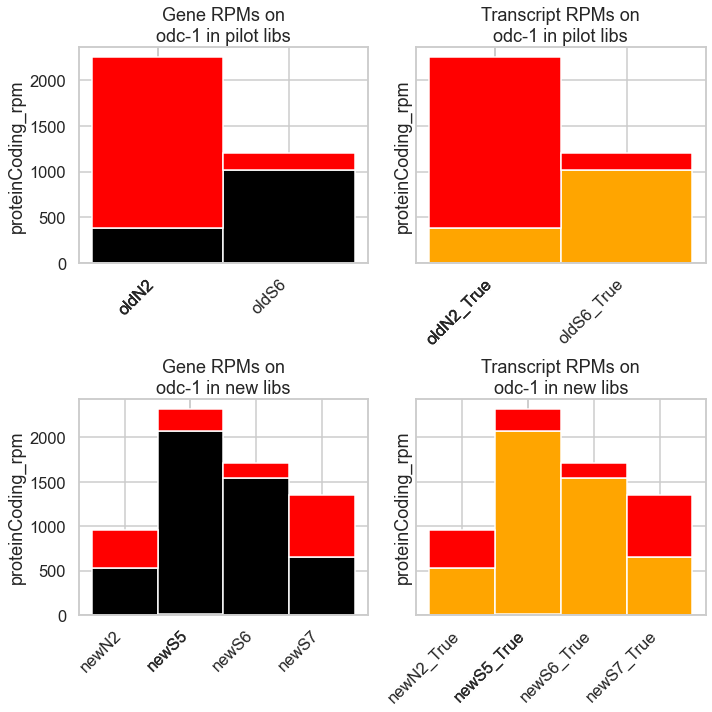

Creating groupby dataframe merged on: ['lib', 'chr_id', 'gene_id', 'gene_name']
	+ [t5] tag


Counting reads per gene: 100%|██████████| 33614/33614 [00:00<00:00, 64359.41it/s]


['oldN2', 'oldN2', 'oldN2', 'oldN2', 'oldN2', 'oldS6', 'oldS6']
Creating groupby dataframe merged on: ['lib', 'chr_id', 'gene_id', 'gene_name']
	+ [t5] tag
	+ [NMD Sensitive Isoform]


Counting reads per gene: 100%|██████████| 33619/33619 [00:00<00:00, 54098.45it/s]


['oldN2_False', 'oldN2_True', 'oldN2_False', 'oldN2_False', 'oldN2_True', 'oldN2_False', 'oldN2_False', 'oldS6_False', 'oldS6_True', 'oldS6_False', 'oldS6_True']
Creating groupby dataframe merged on: ['lib', 'chr_id', 'gene_id', 'gene_name']
	+ [t5] tag


Counting reads per gene: 100%|██████████| 39452/39452 [00:00<00:00, 57668.81it/s]


KeyboardInterrupt: 

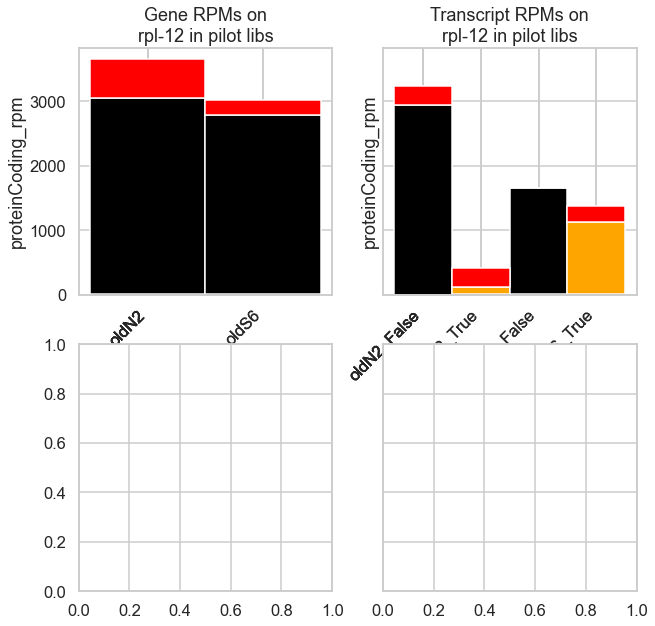

In [5]:
target_gene = 'rpl-3'
context = 'talk'  # 'paper' 'talk' 'poster'

plot_column_suffix = "proteinCoding_rpm"  # "t5group_rpm" or "rpm" or "proteinCoding_rpm"

adapted_species_adjustment_factor = 0.1
show_adapted_species = True

nmd_sensitive_genes_and_txns = (('ubl-1', ['H06I04.4b.1']),
                                ('rpl-3', ['F13B10.2b']),
                                ('odc-1', ['K11C4.4.1']),
                                ('rpl-12', ['JC8.3c.2', 'JC8.3b']),
                                ('rpl-30', ['Y106G6H.3c.1']),
                                ('rpl-1', ['Y71F9AL.13b.4', 'Y71F9AL.13b.2']),
                                ('rpl-26', ['F28C6.7b.1']),
                                ('rps-22', ['F53A3.3b.1']),
                                )

sea.set_style("whitegrid")
sea.set_context(context)
if context == 'paper':
    fig_size = (8, 8)
if context == 'talk':
    fig_size = (10, 10)
if context == 'poster':
    fig_size = (12, 12)


for target_gene, _ in nmd_sensitive_genes_and_txns:
    old_df = old_df_raw.copy(deep=True)
    new_df = new_df_raw.copy(deep=True)
    for potential_target_gene, NMD_sensitive_txns in nmd_sensitive_genes_and_txns:
        if target_gene == potential_target_gene:
            old_df['NMD Sensitive Isoform'] = old_df['transcript_id'].isin(NMD_sensitive_txns)
            new_df['NMD Sensitive Isoform'] = new_df['transcript_id'].isin(NMD_sensitive_txns)
    
    fig, axes = plt.subplots(2, 2, figsize=fig_size,
                             sharex=False,
                             sharey='row')
    
    for row, libs_name in enumerate(['pilot', 'new']):
        if libs_name == 'pilot':
            df = old_df
        else:
            df = new_df
        for col, gene_or_transcript_level in enumerate(['gene', 'transcript']):
            cols_to_index = ['lib', 'chr_id', 'gene_id', 'gene_name']
            reset_index_level = ['lib']
            if gene_or_transcript_level == 'transcript':
                cols_to_index.append('NMD Sensitive Isoform')
                additional_groupby = ['NMD Sensitive Isoform']
                reset_index_level.append('NMD Sensitive Isoform')
            else:
                additional_groupby = None
            
            plot_df = compress_df(df,
                                  keep_transcript_info=False,  # The 'NMD Sensitive Isoform' column will retain this info here!
                                  additional_groupby_columns=additional_groupby,
                                  group_by_t5=True,
                         ).sort_index(level=cols_to_index)
            adapt_df = plot_df.query(f"gene_name == '{target_gene}'").xs('+', level='t5')[f'gene_{plot_column_suffix}'] / adapted_species_adjustment_factor
            unadapt_df = plot_df.query(f"gene_name == '{target_gene}'").xs('-', level='t5')[f'gene_{plot_column_suffix}']
            plot_df = pd.merge(unadapt_df,adapt_df, on=adapt_df.index.names, how='outer',
                               suffixes=('_unadapted', '_adapted')).fillna(0)
            if gene_or_transcript_level == 'transcript':
                hue_col = plot_df.index.get_level_values('NMD Sensitive Isoform')
            else:
                hue_col = None
            
            
            
            
            bar_names = ["_".join(map(str, a)) for a in zip(*[list(plot_df.index.get_level_values(level)) for level in reset_index_level])]
            bar_unadapted_heights = plot_df[f'gene_{plot_column_suffix}_unadapted']
            bar_adapted_heights = plot_df[f'gene_{plot_column_suffix}_adapted']
            print(bar_names)
            axes[row][col].bar(bar_names,
                               bar_unadapted_heights,
                               1,
                               color=['orange' if 'True' in label else 'black' for label in bar_names])
            if show_adapted_species:
                axes[row][col].bar(bar_names,
                                   bar_adapted_heights,
                                   1,
                                   bottom=bar_unadapted_heights,
                                   color='red')
            axes[row][col].set_title(f"{gene_or_transcript_level.title()} RPMs on\n{target_gene} in {libs_name} libs")
            axes[row][col].set_xticks(bar_names, bar_names, rotation=45, ha='right')
            axes[row][col].set_ylabel(plot_column_suffix)
            # print(plot_df[f'gene_{plot_column_suffix}_adapted'] / (plot_df[f'gene_{plot_column_suffix}_unadapted'] + plot_df[f'gene_{plot_column_suffix}_adapted']))
    plt.tight_layout()
    save_path = f"./output_files/isoform_plots/{npCommon.get_dt()}_{target_gene}_{plot_column_suffix}.new.barPlots"
    for file_type in ['.svg', '.png']:
        plt.savefig(save_path + file_type,
                    dpi=300)
    plt.show()
plot_df

# Plotting Tails of isoforms

This shows a very interesting effect! It looks like most NMD target transcripts captured are nacent mRNAs, that have yet to reach the "steady state" tail lengths that we see with non-NMD target transcripts. We assume these non-target reads are coming from mRNAs that have entered the translation pool.

### Feb 22, 2023 Notes:
I have a few ToDo's remaining for this analysis:
1. First, Josh reccomended that I try to subsample the "steady state" mRNA population (the non-NMD targets) and see how often I end up with a distribution similar to the adapted (post cleavage) NMD target reads. This would allow me to get an idea of the variabilty of the technique, and ifwhat I am seeing with sPM57/58 is within noise.
2. Second, I should try and set up some kind of "full length" cutoff for all of the reads that are not adapted. This would let me account for the imcomplete ligation of the 5TERA adapter that I thnk I am getting!

In [6]:
import matplotlib
def plot_tails_from_isoforms(target_gene, df_to_plot, plot_type='ecdfPlot', show_adapted_species = False, save_dir=".", width_per_lib=4, height=8):
    """
    
    :param target_gene:
    :param plot_type: 'boxPlot' or 'ecdfPlot' or 'violinPlot'
    :param show_adapted_species: True or False
    :return: 
    """
    lib_set = "all"
    target_df = df_to_plot
    plot_df = target_df.set_index(['lib', 'gene_id', 'gene_name', 't5', 'transcript_id']).xs((target_gene, '-'), level=(
    'gene_name', 't5')).reset_index()
    for potential_target_gene, NMD_sensitive_txns in nmd_sensitive_genes_and_txns:
        if target_gene == potential_target_gene:
            plot_df['NMD Sensitive Isoform'] = plot_df['transcript_id'].isin(NMD_sensitive_txns)
    unique_libs = plot_df.lib.unique()
    unique_lib_count = len(unique_libs)
    fig, axes = plt.subplots(1, unique_lib_count, figsize=(width_per_lib * unique_lib_count, height),
                             sharex='all',
                             sharey='all')
    plt.suptitle(f"Poly(A) Tail Lengths for {target_gene}")
    sea.set_style("whitegrid")
    sea.set_context("poster")
    ticks = [10, 100, 1000]
    tick_line_factors = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    tick_lines = [a * b for a, b in product(ticks, tick_line_factors)]
    tick_labels = [str(int(label)) if label in ticks else '' for label in tick_lines]
    for i, unique_lib in enumerate(unique_libs):
        if plot_type == 'boxPlot':
            sea.boxplot(plot_df.query(f"lib == '{unique_lib}'"),
                        y='polya_length',
                        x='NMD Sensitive Isoform',
                        ax=axes[i])
            axes[i].set_yscale('log')
            axes[i].set_yticks(tick_lines)
            axes[i].set_ylim((2, 500))
            axes[i].set_yticklabels(tick_labels)
        elif plot_type == 'violinPlot':
            try:
                sea.violinplot(plot_df.query(f"lib == '{unique_lib}'"),
                               y='polya_length',
                               x='lib',
                               hue='NMD Sensitive Isoform',
                               ax=axes[i],
                               split=True)
            except ValueError:
                sea.violinplot(plot_df.query(f"lib == '{unique_lib}'"),
                               y='polya_length',
                               x='lib',
                               hue='NMD Sensitive Isoform',
                               ax=axes[i])
            axes[i].set_yscale('log')
            axes[i].set_yticks(tick_lines)
            axes[i].set_yticklabels(tick_labels)
            axes[i].get_legend().remove()
        elif plot_type == 'ecdfPlot':
            sea.ecdfplot(plot_df.query(f"lib == '{unique_lib}'"),
                         x='polya_length',
                         hue='NMD Sensitive Isoform',
                         ax=axes[i],
                         linewidth=5,
                         )
            axes[i].set_xscale('log')
            axes[i].set_xticks(tick_lines)
            axes[i].set_xticklabels(tick_labels)
            axes[i].set_xlim((5, 500))
            axes[i].get_legend().remove()
        else:
            raise NotImplementedError(
                f"{plot_type} is not currently supported! b/c I haven't coded it or you have a typo...")
        lib_converter = {'oldN2': 'Wildtype (pilot)',
                         'oldS6': 'Δsmg-6 (pilot)',
                         'newN2': 'Wildtype (new)',
                         'newS5': 'Δsmg-5 (new)',
                         'newS6': 'Δsmg-6 (new)',
                         'sPM57': 'Wildtype (Parissa)',
                         'sPM58': '~Wildtype (Parissa)',
                         }
        axes[i].set_title(f"{lib_converter[unique_lib]}")
    if plot_type == 'ecdfPlot': 
        plt.legend(["True", "False"],
                   bbox_to_anchor=(0.9, 0.99),
                   loc="upper right",
                   bbox_transform=fig.transFigure, ncol=2,
                   title=f'NMD Sensitive Isoform',
                   handlelength=1.5,
                   fontsize='x-small',
                   title_fontsize='x-small',)
    elif plot_type == 'violinPlot':
        handles, labels = axes[-1].get_legend_handles_labels()
        fig.legend(handles, labels, bbox_to_anchor=(1, 1),
                   loc="upper right",
                   bbox_transform=fig.transFigure, ncol=2,
                   title=f'NMD Sensitive Isoform',
                   fontsize='x-small',
                   title_fontsize='x-small')
    plt.tight_layout()
    save_path = f"{save_dir}/{npCommon.get_dt()}_{target_gene}_tails_{lib_set}.{plot_type}"
    for file_type in ['.svg', '.png']:
        plt.savefig(save_path + file_type,
                    dpi=300)
    plt.show()

KeyError: 'newS7'

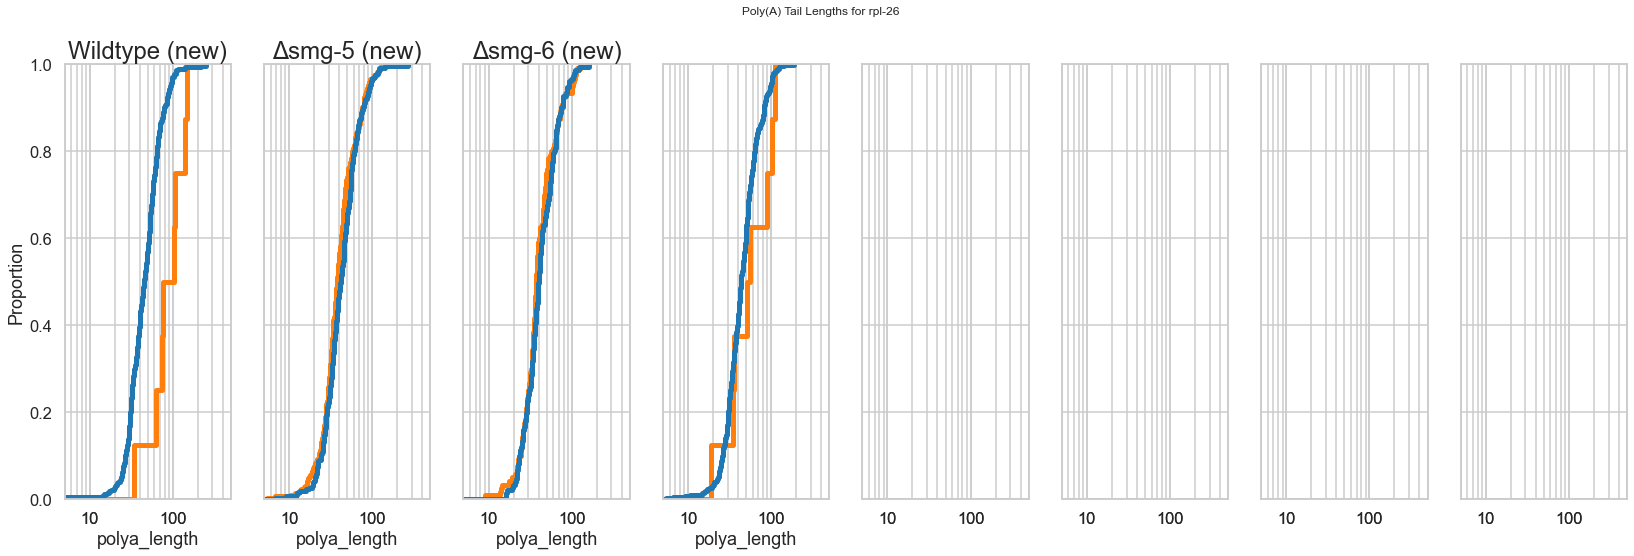

In [7]:
nmd_sensitive_genes_and_txns = (# ('ubl-1', ['H06I04.4b.1']),
                                #('rpl-3', ['F13B10.2b']),
                                #('odc-1', ['K11C4.4.1']),
                                # ('rpl-12', ['JC8.3c.2', 'JC8.3b']),
                                #('rpl-30', ['Y106G6H.3c.1']),
                                #('rpl-1', ['Y71F9AL.13b.4', 'Y71F9AL.13b.2']),
                                ('rpl-26', ['F28C6.7b.1']),
                                )

target_genes = [gene for gene, _ in nmd_sensitive_genes_and_txns]
plot_types = [
    'ecdfPlot',
    'boxPlot',
    'violinPlot',
]

for gene, plot_kind in product(target_genes, plot_types):
    target_gene_folder_path = f"./output_files/isoform_plots/{npCommon.get_dt()}_tailPlots_from_{gene}"
    try:
        os.mkdir(target_gene_folder_path)
    except FileExistsError:
        pass
    plot_df = reads_df_raw.copy(deep=True)
    plot_tails_from_isoforms(gene, plot_df, plot_type=plot_kind,
                             save_dir=target_gene_folder_path,
                             width_per_lib=3.5,
                             height=8)

# Long to wide tool
Let's try and see if I can write a simple long_to_wide tool

This would be great for my general ability to split libs up and compare across them


In [8]:
df = reads_df_raw.copy(deep=True)
comp_df = compress_df(df,
                      keep_transcript_info=False,).sort_index(level=['lib', 'chr_id', 'gene_id', 'gene_name'])
# print(comp_df.columns)
long_to_wide(comp_df, wide_target_cols=['gene_rpm', 'mean_polya_length'])

Creating groupby dataframe merged on: ['lib', 'chr_id', 'gene_id', 'gene_name']
	+ [t5] tag


Counting reads per gene: 100%|██████████| 110723/110723 [00:01<00:00, 56283.30it/s]


,chr_id,gene_id,gene_name,t5,gene_rpm_newN2,gene_rpm_newS5,gene_rpm_newS6,gene_rpm_newS7,gene_rpm_oldN2,gene_rpm_oldS6,gene_rpm_sPM57,gene_rpm_sPM58,mean_polya_length_newN2,mean_polya_length_newS5,mean_polya_length_newS6,mean_polya_length_newS7,mean_polya_length_oldN2,mean_polya_length_oldS6,mean_polya_length_sPM57,mean_polya_length_sPM58
0,I,WBGene00000001,aap-1,+,0.0,0.000000,0.000000,0.000000,0.000000,5.936832,0.000000,0.000000,0.0,0.0000,0.000,0.000,0.000000,32.320,0.000,0.000000
1,I,WBGene00000001,aap-1,-,0.0,0.000000,0.000000,0.000000,13.104246,0.000000,7.473506,0.000000,0.0,0.0000,0.000,0.000,57.383333,0.000,37.126,0.000000
2,I,WBGene00000006,aat-5,+,0.0,0.000000,0.000000,0.000000,1.872035,0.000000,1.067644,0.000000,0.0,0.0000,0.000,0.000,40.320000,0.000,82.260,0.000000
3,I,WBGene00000006,aat-5,-,0.0,32.854749,33.557047,7.611682,5.616105,5.936832,7.473506,15.195288,0.0,52.6900,71.085,19.100,65.926667,185.000,121.908,88.895714
4,I,WBGene00000010,aat-9,+,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.135288,0.000000,0.0,0.0000,0.000,0.000,0.000000,0.000,64.425,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29731,X,WBGene00304189,C52E12.11,+,0.0,0.000000,0.000000,7.611682,1.872035,5.936832,1.067644,0.000000,0.0,0.0000,0.000,92.480,0.000000,34.480,0.000,0.000000
29732,X,WBGene00304189,C52E12.11,-,0.0,114.991622,67.114094,144.621966,5.616105,41.557825,2.135288,7.597644,0.0,59.4025,81.060,47.804,129.226667,42.275,53.855,90.576667
29733,X,WBGene00304237,F39B3.7,-,0.0,0.000000,0.000000,7.611682,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.000,69.700,0.000000,0.000,0.000,0.000000
29734,unc-54,WBGene00004677,rrn-3.56,-,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.067644,0.000000,0.0,0.0000,0.000,0.000,0.000000,0.000,54.710,0.000000


# Scatter plot of isoform RPMS
Make a scatter plot of isoforms and their RPMs between N2 and smg-5/6 treatments. Maybe this will better pick out things like rpl-12 which I have missed but is obviously a great target!

This will be a little annoying b/c i'll need to split and re-merge the columns!

#
## Better option (In next cell down!):
I think the above design for a scatter doesn't work because the actual isoforms of interest are not changing that dramatically. A better way to plot this would be to figure out the fraction that gene makes up of the total RPM, then plot that ratio between two libs. 

A NMD sensitive isoform would light up in this analysis because it's suddenly making up a way larger portion of the total gene's RPM when I break NMD vs in WT.

In [ ]:
plot_col = 'transcript_rpm'

df = reads_df_raw.query("lib == 'oldN2' | lib == 'oldS6'").copy(deep=True)
compressed_df = compress_df(df, group_by_t5=False)

lib_names = compressed_df.index.get_level_values('lib').to_series().unique()

dfs = []
for lib in lib_names:
    dfs.append(compressed_df.query(f"lib == '{lib}'").reset_index(level='lib')[plot_col].rename(f"{plot_col}_{lib}"))
plot_df = pd.concat(dfs, axis=1).fillna(0)

fig = px.scatter(plot_df.reset_index(),
                 x=f'{plot_col}_{lib_names[0]}',
                 y=f'{plot_col}_{lib_names[1]}',
                 hover_name='gene_name',
                 hover_data=['transcript_id'])
fig.show(renderer='browser')

# Trying to plot change in isoform usage within genes

Like noted in the above markdown cell. This is kinda a weird analysis but it does capture different information than the rocket plots!

In [ ]:
df = reads_df_raw.query("lib == 'oldN2' | lib == 'oldS6'").copy(deep=True)
compressed_df = compress_df(df, group_by_t5=False)

mini_df = compressed_df.sort_values(["lib", "gene_id"])[['transcript_hits', 'transcript_rpm', 'transcript_proteinCoding_rpm']]
# Cool way to do this from: https://stackoverflow.com/questions/23377108/pandas-percentage-of-total-with-groupby
mini_df['fraction_of_gene_rpm'] = mini_df['transcript_rpm'] / mini_df.groupby(['lib', 'gene_id'])['transcript_rpm'].transform('sum')
mini_df['test_col'] = mini_df['fraction_of_gene_rpm'] * mini_df.groupby(['lib', 'gene_id'])['transcript_rpm'].transform('sum')

wide_mini_df = long_to_wide(mini_df, wide_target_cols=['fraction_of_gene_rpm', 'transcript_rpm'])
wide_mini_df['combined_rpm'] = wide_mini_df.transcript_rpm_oldN2 + wide_mini_df.transcript_rpm_oldS6 + 5
wide_mini_df = wide_mini_df.query("combined_rpm >= 100").query("fraction_of_gene_rpm_oldN2 + fraction_of_gene_rpm_oldS6 != 2")
wide_mini_df['long_name'] = wide_mini_df.gene_name + " (" + wide_mini_df.transcript_id + ")"

fig = px.scatter(wide_mini_df,
                 x='fraction_of_gene_rpm_oldN2',
                 y='fraction_of_gene_rpm_oldS6',
                 size='combined_rpm',
                 size_max=25,
                 hover_name='long_name')
fig.show(renderer='browser')

# Trying to combine tail and isoform information
So for some genes like rpl-30, the splice junction is long and ahead of the NMD eliciting STOP so that most of the degradation intermediates retain splice information. This makes it clear that they came from the NMD isoform! Genes like ubl-1 are very much the opposite case, in that all degradation intermediates are completely ambiguous as it if they came from NMD or not... *(but we ~know they did)*

I want to try and get code working that is able to take advantage of these few genes where deg. intermediates retain isoform information. That's what this next section will do.

Two large pieces fall into this:
1. We have to make sure that reads that do not have enough information to confidently ID the right isoform are not arbitrarily getting assigned
2. Plot tail lengths with the combinations of adapted/unadapted and NMD sensitive/insensitive


### Feb 23, 2023:
I should really try and get a bootstrapping test of this going to see how often I see the NMD adapted type tails coming out of the unadapted NMD insensitive reads


oldN2 rpl-30
Making new directory at: /home/marcus/Insync/marcus.viscardi@gmail.com/Google Drive/insync_folder/5TERA_ReadsAndTails_Plots/raw_figures_from_python/230321_isoformTailPlots_oldN2-oldS6


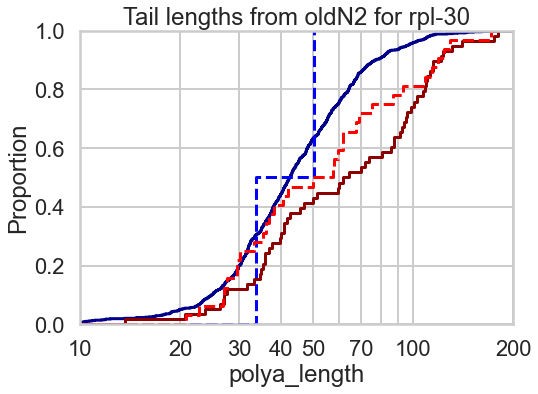

oldS6 rpl-30


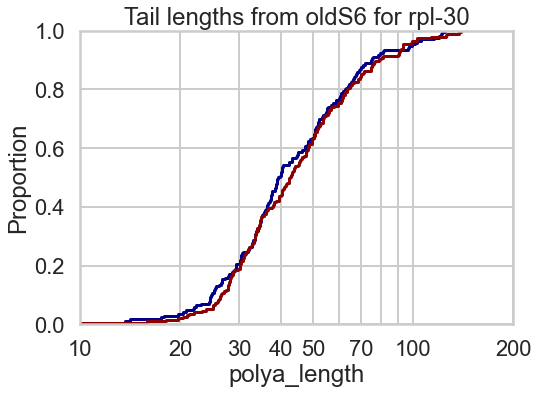

oldN2 ubl-1


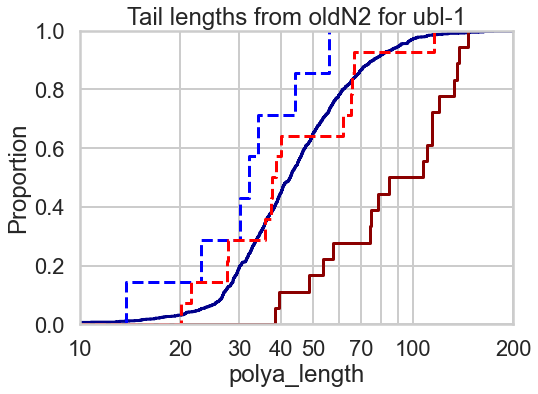

oldS6 ubl-1


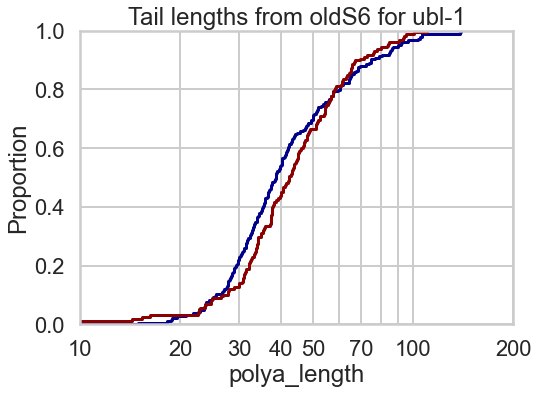

oldN2 rps-22


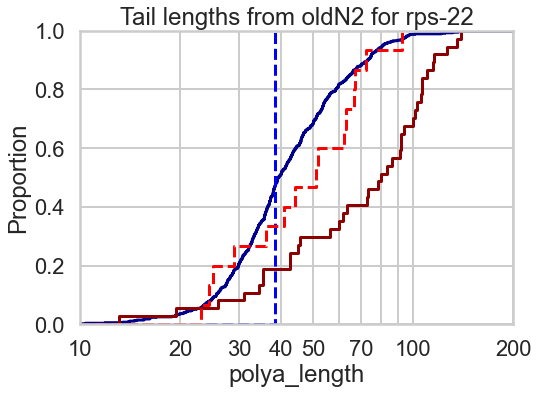

oldS6 rps-22


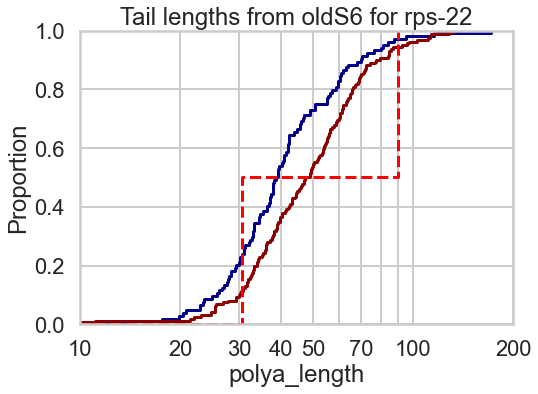

In [9]:
log_xaxis = True

target_libs = (# "newN2",
               "oldN2",
               "oldS6",
               # "newS6",
               # "newS5",
               # "sPM57",
               # "sPM58",
               )

# At the isoform edge position we can differentiate cleavage species' parent isoform, left of which, we have enough info to differentiate between the NMD sensitive or insenstive isoforms!
# I manually identified that same isoform edge information for the following genes:
targets_and_iso_edge_dict = {"rpl-30": [10_436_409, 'left'],
                             # "rpl-26": [8_603_272, 'left'],
                             # "rpl-3": [3_868_327, 'left'],
                             # "rpl-1": [2_876_019, 'right'],
                             # "rpl-12": [13_240_023, 'right'],
                             "ubl-1": [3_068_573, 'left'],
                             "rps-22": [1_950_996, 'left']
                             }

nmd_sensitive_genes_and_txns = (('ubl-1', ['H06I04.4b.1']),
                                ('rpl-3', ['F13B10.2b']),
                                ('odc-1', ['K11C4.4.1']),  # This analysis isn't quite the same...
                                ('rpl-12', ['JC8.3c.2', 'JC8.3b']),
                                ('rpl-30', ['Y106G6H.3c.1']),
                                ('rpl-1', ['Y71F9AL.13b.4', 'Y71F9AL.13b.2']),
                                ('rpl-26', ['F28C6.7b.1']),
                                ('rps-22', ['F53A3.3b.1']),
                                )

sea.set_style("whitegrid")
sea.set_context("poster")

palette = {"NMD'ed: +  t5: -":"darkred",
           "NMD'ed: +  t5: +":"red", 
           "NMD'ed: -  t5: -":"darkblue",
           "NMD'ed: -  t5: +":"blue"}


def plots_tails(library_df, targeted_gene, lib_target, save_dir=f"./output_files/isoform_plots/NMD_and_Adapted_tailPlots"):
    fig, ax = plt.subplots(figsize=(8, 6))
    g = sea.ecdfplot(library_df.sort_values('NMD_and_t5'),
                     ax=ax,
                     x='polya_length',
                     hue='NMD_and_t5',
                     palette=palette,
                     log_scale=log_xaxis,
                     )
    # Change the line styles:
    for i, line in enumerate(g.lines):
        if line.get_color().startswith("dark"):
            line.set_linestyle("-")
        else:
            line.set_linestyle("--")
    plt.title(f"Tail lengths from {lib_target} for {targeted_gene}")
    if log_xaxis:
        ax.set_xbound(10, 200)
        ax.set_xticks([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200])
        ax.set_xticklabels([10, 20, 30, 40, 50, None, 70, None, None, 100, 200])
    else:
        ax.set_xbound(-1, 200)
    # sea.move_legend(g, "lower right")
    ax.get_legend().remove()
    plt.tight_layout()
    save_dir = Path(save_dir)
    if not save_dir.exists():
        print(f"Making new directory at: {save_dir}")
        save_dir.mkdir()
    
    save_path = str(save_dir) + f"/{npCommon.get_dt()}_{targeted_gene}_{lib_target}_NMD-and-t5_tailLength.ecdf"
    if log_xaxis:
        save_path += ".logAxis"
    for file_type in ['.svg', '.png']:
        plt.savefig(save_path + file_type, dpi=300)
    plt.show()


for target_gene, (iso_edge, left_or_right) in targets_and_iso_edge_dict.items():
    if left_or_right == 'left':
        comparator = "<="
        anti_comparator = ">="
    elif left_or_right == 'right':
        comparator = ">="
        anti_comparator = "<="
    else:  # This is just to shut pycharm up
        comparator = None
        anti_comparator = None
    if target_gene == 'ubl-1':
        df = reads_df_raw.copy(deep=True).query(f"gene_name == '{target_gene}'")
    else:
        df = reads_df_raw.copy(deep=True).query(f"gene_name == '{target_gene}'").query(f"chr_pos {comparator} {iso_edge}")
    nmd_sensitive_genes_and_txns_dict = {potential_target_gene: NMD_sensitive_txns for potential_target_gene, NMD_sensitive_txns in nmd_sensitive_genes_and_txns}
    df['NMD_Sensitive_Isoform'] = df['transcript_id'].isin(nmd_sensitive_genes_and_txns_dict[target_gene]).replace({True: '+', False: '-'})
    if target_gene == 'ubl-1':
        df.NMD_Sensitive_Isoform.mask(((df.t5 == '+') & (df.eval(f"chr_pos {anti_comparator} {iso_edge}"))), '+', inplace=True)
    
    for lib_for_tail_plot in df.lib.unique():
        if lib_for_tail_plot not in target_libs:
            continue
        print(lib_for_tail_plot, target_gene)
        lib_df = df.query(f"lib == '{lib_for_tail_plot}'").copy()
        lib_df['NMD_and_t5'] = lib_df.apply(lambda row: f"NMD'ed: {str(row['NMD_Sensitive_Isoform'])}  t5: {row['t5']}", axis=1)

        plots_tails(lib_df, target_gene, lib_for_tail_plot,
                    save_dir=f"/home/marcus/Insync/marcus.viscardi@gmail.com/Google Drive/insync_folder/5TERA_ReadsAndTails_Plots/raw_figures_from_python/{npCommon.get_dt()}_isoformTailPlots_{'-'.join(target_libs)}")

# Read Plotting W/ Isoforms

The goal here is to run my read plotting and coverage plotting scripts, but leverage the additional isoform information from FLAIR.

# Make it prettier

The below code shows how to make subsets of plots, which might be really nice for making the plots more manageable!
[Link to StackOverflow where I got this from!](https://stackoverflow.com/a/67694491/13316742)

Making plots for ubl-1
Calculating coverage for NMD-(+) isoform in oldN2 lib:
Calculating coverage for NMD-(-) isoform in oldN2 lib:
Calculating coverage for NMD-(~) isoform in oldN2 lib:


/tmp/ipykernel_1057475/3584440603.py:147: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  adapted_axes[0].get_shared_y_axes().join(*adapted_axes)
/tmp/ipykernel_1057475/3584440603.py:148: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  unadapted_axes[0].get_shared_y_axes().join(*unadapted_axes)


Making new directory at: /home/marcus/Insync/marcus.viscardi@gmail.com/Google Drive/insync_folder/5TERA_ReadsAndTails_Plots/raw_figures_from_python/230321_coveragePlots3_oldN2
Saving file to /home/marcus/Insync/marcus.viscardi@gmail.com/Google Drive/insync_folder/5TERA_ReadsAndTails_Plots/raw_figures_from_python/230321_coveragePlots3_oldN2/ubl-1_oldN2_coveragePlots_withAmbiguouslyAssignedReads.svg/png


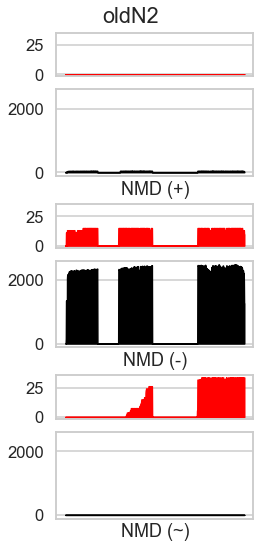

Calculating coverage for NMD-(+) isoform in oldN2 lib:
Calculating coverage for NMD-(-) isoform in oldN2 lib:
Calculating coverage for NMD-(~) isoform in oldN2 lib:
Calculating coverage for NMD-(+) isoform in oldS6 lib:
Calculating coverage for NMD-(-) isoform in oldS6 lib:
Calculating coverage for NMD-(~) isoform in oldS6 lib:


/tmp/ipykernel_1057475/3584440603.py:147: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  adapted_axes[0].get_shared_y_axes().join(*adapted_axes)
/tmp/ipykernel_1057475/3584440603.py:148: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  unadapted_axes[0].get_shared_y_axes().join(*unadapted_axes)


Making new directory at: /home/marcus/Insync/marcus.viscardi@gmail.com/Google Drive/insync_folder/5TERA_ReadsAndTails_Plots/raw_figures_from_python/230321_coveragePlots3_oldN2-oldS6
Saving file to /home/marcus/Insync/marcus.viscardi@gmail.com/Google Drive/insync_folder/5TERA_ReadsAndTails_Plots/raw_figures_from_python/230321_coveragePlots3_oldN2-oldS6/ubl-1_oldN2-oldS6_coveragePlots_withAmbiguouslyAssignedReads.svg/png


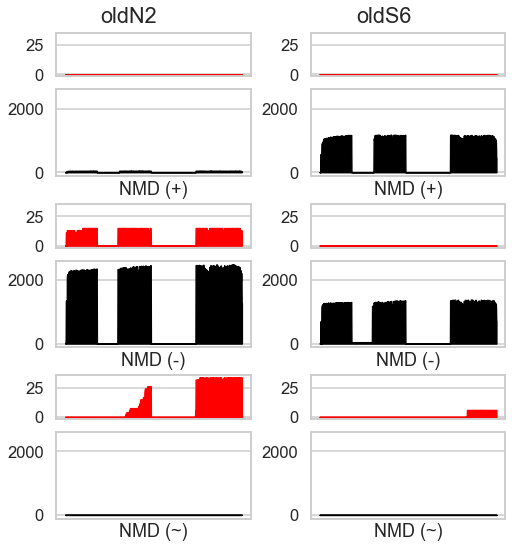

In [10]:
from nanoporeReadPlotting.finalizingReadAndCoveragePlotting_matplotlib import coverage_plotting_5tera

sea.set_style("whitegrid")
sea.set_context("talk")

target_genes = {# "rpl-30",
                # "rpl-26",
                # "rpl-3",
                # "rpl-1",
                # "rpl-12",
                "ubl-1",
                # 'aly-3',
                # 'K08D12.3',
                # 'hel-1',
                # 'rsp-1',
                # 'rps-22',
                }

iso_edge_dict = {
    # gene: [edge, compare, anticompare]
    "rpl-30": [10_436_409, "<=", ">="],
    "rpl-26": [8_603_272, "<=", ">="],
    "rpl-3": [3_868_327, "<=", ">="],
    "rpl-1": [2_876_019, ">=", "<="],
    "rpl-12": [13_240_023, ">=", "<="],
    "ubl-1": [3_068_573, "<=", ">="],
    "rps-22": [1_950_996, "<=", ">="]
    }

nmd_sensitive_genes_and_txns = (('ubl-1', ['H06I04.4b.1']),
                                ('rpl-3', ['F13B10.2b']),
                                ('odc-1', ['K11C4.4.1']),  # This analysis isn't quite the same... b/c only 1 isoform
                                ('rpl-12', ['JC8.3c.2', 'JC8.3b']),
                                ('rpl-30', ['Y106G6H.3c.1']),
                                ('rpl-1', ['Y71F9AL.13b.4', 'Y71F9AL.13b.2']),
                                ('rpl-26', ['F28C6.7b.1']),
                                ('rps-22', ['F53A3.3b.1']),
                                ('rsp-1', ['W02B12.3b.2']),
                                ('hel-1', ['C26D10.2b']),
                                ('K08D12.3', ['K08D12.3b.1']),
                                ('aly-3', ['M18.7b']),
                                )

compare_libs_sets = (("oldN2",),
                     ("oldN2", "oldS6"),
                     # ("sPM57", "sPM58"),
                     # ("newN2", "oldN2", "newS5", "newS6", "oldS6"),
                     )

def plot_coverages_for_isoforms(plot_df, target_gene, compare_libs,
                                targets_and_nontargets_side_by_side=True,
                                plot_ambiguous_reads=False,
                                quiet=True, save_dir=None):
    num_compare_libs = len(compare_libs)
    if not quiet:
        print(f"comparing {num_compare_libs} libraries: {' '.join(compare_libs)}")
    if targets_and_nontargets_side_by_side:
        fig_size = [5, 2.5 * num_compare_libs]  # Width, Height
        if plot_ambiguous_reads:
            fig_size[1] += 1.25 * num_compare_libs
        outer_row_num, outer_col_num = num_compare_libs, 1
    else:
        fig_size = [3.5 * num_compare_libs, 5]  # Width, Height
        if plot_ambiguous_reads:
            fig_size[1] += 2.5
        outer_row_num, outer_col_num = 1, num_compare_libs
    
    fig = plt.figure(constrained_layout=True,
                     figsize=fig_size,
                     )
    # This will produce sets of sub-figures that we can build up figures inside! These could be 1 'subfig' per lib.
    subfigs = fig.subfigures(outer_row_num,
                             outer_col_num)  # Rows, Cols. This could work the other way too!
    
    if num_compare_libs == 1:
        flat_subfigs = [subfigs]
    else:
        flat_subfigs = subfigs.flat
    # This will allow me to save all of these into a list, then I can force them to all share Y-scale!
    adapted_axes = []
    unadapted_axes = []
    for outer_index, (subfig, lib) in enumerate(zip(flat_subfigs, compare_libs)):
        subfig.suptitle(lib)
        lib_df = plot_df.query(f"lib == '{lib}'").copy()

        if targets_and_nontargets_side_by_side:
            subfig_rows, subfig_cols = 2, 2
            height_ratios = [1, 2]
            if plot_ambiguous_reads:
                subfig_cols += 1
        else:
            subfig_rows, subfig_cols = 4, 1
            height_ratios = [1, 2, 1, 2]
            if plot_ambiguous_reads:
                subfig_rows += 2
                height_ratios += [1, 2]

        # Other option here would be to make the libs stack: 4 rows, 1 col. The unstacking code below will handle either option!
        axes = subfig.subplots(subfig_rows,  # num rows: adapted & unadapted
                               subfig_cols,  # num cols: NMD sensitive and not sensitive
                               height_ratios=height_ratios,
                               )
        if len(axes.shape) == 2 and axes.shape[0] == 2:
            target_axes, nontarget_axes = axes.transpose()
            ambiguous_axes = None
        elif len(axes.shape) == 2 and axes.shape[0] == 3:  # In the case of plotting ambiguous reads!
            target_axes, nontarget_axes, ambiguous_axes = axes.transpose()
        elif len(axes.shape) == 1 and axes.shape[0] == 4:
            target_axes, nontarget_axes = np.array_split(axes, 2)
            ambiguous_axes = None
        elif len(axes.shape) == 1 and axes.shape[0] == 6:  # In the case of plotting ambiguous reads!
            target_axes, nontarget_axes, ambiguous_axes = np.array_split(axes, 3)
        else:
            raise NotImplementedError
        
        NMD_target_iterator = ['+', '-']
        axes_group_iterator = [target_axes, nontarget_axes]
        
        adapted_axes += [target_axes[0], nontarget_axes[0]]
        unadapted_axes += [target_axes[1], nontarget_axes[1]]
        if plot_ambiguous_reads:
            adapted_axes += [ambiguous_axes[0]]
            unadapted_axes += [ambiguous_axes[1]]
        
        if not plot_ambiguous_reads:
            axes_iterator = zip(NMD_target_iterator, axes_group_iterator)
        else:
            NMD_target_iterator += ['~']
            axes_group_iterator += [ambiguous_axes]
            axes_iterator = zip(NMD_target_iterator, axes_group_iterator)
        
        for target, target_or_non_axes in axes_iterator:  # Either two steps here or three (if ambiguous reads getting plotted!)
            print(f"Calculating coverage for NMD-({target}) isoform in {lib} lib:")
            # print(lib_df.query(f"NMD_Sensitive_Isoform == '{target}'"))
            coverage_plotting_5tera(lib_df,
                                    gene_name=target_gene,
                                    provide_axes=target_or_non_axes,
                                    rpm_normalize=True,
                                    additional_plot_df_query=f"NMD_Sensitive_Isoform == '{target}'",
                                    # it's import to filter inside of this method rather than ahead of time, this is b/c the coverage_plotting script uses all the reads to calculate rpm!!
                                    quiet=quiet,
                                    )
            target_or_non_axes[1].set_xlabel(f"NMD ({target})")
            if targets_and_nontargets_side_by_side and target == '-':
                target_or_non_axes[0].set_yticklabels([])
                target_or_non_axes[1].set_yticklabels([])
    adapted_axes[0].get_shared_y_axes().join(*adapted_axes)
    unadapted_axes[0].get_shared_y_axes().join(*unadapted_axes)
    # plt.subplots_adjust(wspace=0, hspace=0)
    libs_string = '/'.join(compare_libs)
    # plt.suptitle(f"Read Coverage for {target_gene}\nin {libs_string}")
    if isinstance(save_dir, str):
        save_dir = Path(save_dir)
        if not save_dir.exists():
            print(f"Making new directory at: {save_dir}")
            save_dir.mkdir()
        save_path = str(save_dir) + f"/{target_gene}_{'-'.join(compare_libs)}_coveragePlots"
        if plot_ambiguous_reads:
            save_path += "_withAmbiguouslyAssignedReads"
        print(f"Saving file to {save_path}.svg/png")
        for file_type in ('.svg', '.png'):
            plt.savefig(save_path + file_type)
    plt.show()


for target_gene in target_genes:
    print(f"Making plots for {target_gene}")
    df = reads_df_raw.copy(deep=True)  #.sample(100000)  # TODO: Drop this sample step, it just made things faster
    nmd_sensitive_genes_and_txns_dict = {potential_target_gene: NMD_sensitive_txns for potential_target_gene, NMD_sensitive_txns in nmd_sensitive_genes_and_txns}
    df['NMD_Sensitive_Isoform'] = df['transcript_id'].isin(nmd_sensitive_genes_and_txns_dict[target_gene]).replace({True: '+', False: '-'})
    if target_gene == 'ubl-1':
        iso_edge, comparator, anti_comparator = iso_edge_dict[target_gene]
        df.NMD_Sensitive_Isoform.mask(((df.t5 == '+') & (df.eval(f"chr_pos {anti_comparator} {iso_edge}"))), '~', inplace=True)
    for compare_libs in compare_libs_sets:
        plot_coverages_for_isoforms(df, target_gene, compare_libs,
                                    targets_and_nontargets_side_by_side=False,
                                    save_dir=f"/home/marcus/Insync/marcus.viscardi@gmail.com/Google Drive/insync_folder/5TERA_ReadsAndTails_Plots/raw_figures_from_python/{npCommon.get_dt()}_coveragePlots3_{'-'.join(compare_libs)}",
                                    plot_ambiguous_reads=True,
                                    quiet=True)

In [11]:
target_gene = 'ubl-1'
df = reads_df_raw.copy(deep=True)  #.sample(100000)  # TODO: Drop this sample step, it just made things faster
nmd_sensitive_genes_and_txns_dict = {potential_target_gene: NMD_sensitive_txns for potential_target_gene, NMD_sensitive_txns in nmd_sensitive_genes_and_txns}
df['NMD_Sensitive_Isoform'] = df['transcript_id'].isin(nmd_sensitive_genes_and_txns_dict[target_gene]).replace({True: '+', False: '-'})
iso_edge, comparator, anti_comparator = iso_edge_dict[target_gene]
df.NMD_Sensitive_Isoform.mask(((df.t5 == '+') & (df.eval(f"chr_pos {anti_comparator} {iso_edge}"))), '~', inplace=True)

df.query(f"gene_name == '{target_gene}'").query(f"NMD_Sensitive_Isoform == '~'").query(f"lib == 'oldN2'")[['read_id', 't5', 'gene_name_original', 'transcript_id', 'gene_name', 'gene_name_fromGeneAssign', 'NMD_Sensitive_Isoform']]

,read_id,t5,gene_name_original,transcript_id,gene_name,gene_name_fromGeneAssign,NMD_Sensitive_Isoform
199011,6ee0f5c2-7c0c-42c7-ae54-d0e2ff3191c2,+,ubl-1,H06I04.4a.1,ubl-1,ubl-1,~
199015,15e968d3-e046-42e9-9caf-fedb0d3429a0,+,ubl-1,H06I04.4a.1,ubl-1,ubl-1,~
199021,d5d4b9b3-73c6-4602-84e3-c7ec38c4330f,+,ubl-1,H06I04.4a.1,ubl-1,ubl-1,~
199022,06c17020-3244-4ea7-af42-ed745051d668,+,ubl-1,H06I04.4a.1,ubl-1,ubl-1,~
199028,6729fe6e-2bb0-437e-870c-05f5404f5eb7,+,ubl-1,H06I04.4a.1,ubl-1,ubl-1,~
199029,dddfebc8-4770-4bfa-9b09-fb307225e361,+,ubl-1,H06I04.4a.1,ubl-1,ubl-1,~
199031,069c939a-48be-4df5-9017-2211e18df0ce,+,ubl-1,H06I04.4a.1,ubl-1,ubl-1,~
199032,34603282-4a0f-44a0-9382-8f3c827e37ad,+,ubl-1,H06I04.4a.1,ubl-1,ubl-1,~
199038,3f59b0ab-785c-4084-b62b-2f778dde769a,+,ubl-1,H06I04.4a.1,ubl-1,ubl-1,~
199040,556d0d6a-dce1-4078-93a6-e16242d8a6b8,+,ubl-1,H06I04.4a.1,ubl-1,ubl-1,~


***

# *ets-4* Weirdness
I've had some weirdness going on with *ets-4* where it doesn't seem like it's being assigned correctly. I'm going to try to explore this.

I think part of what's happening is that the annotation for *ets-4* overlaps with another gene (*ceh-60*), and for whatever reason this is tanking assignments(?).

For example, I can see on IGV that there are 30 clear reads in my oldN2 lib on *ets-4*. But **ZERO(?!)** of these make it to this stage... why?

The only read I see from oldN2 is "f1250dbe-d5f9-47a6-a60f-d55ff5a6f909", and this read is obviously from *ceh-60* when you look at it on IGV. It's in the opposite direction ffs!

Is FLAIR not strand aware?! That seems like a massive oversight...

**I need to go look if I am using FLAIR incorrectly, or if I forgot a stand-aware flag of some sort**

In [57]:
reads_df_raw.query("gene_name == 'ets-4' | gene_name_fromGeneAssign == 'ets-4'")

,read_id,bit_flag,chr_id,chr_pos,mapq,cigar,r_next,p_next,len,sequence,phred_qual,AS,NM,SA,cm,de,ms,nn,rl,s1,s2,t3,t5,tp,ts,zd,strand,qc_tag_featc,qc_pass_featc,gene_id_original,gene_name_original,chr,leader_start,adapter_start,polya_start,transcript_start,read_rate,polya_length,qc_tag_polya,read_length,transcript_id,original_chr_pos,gene_id,gene_name,gene_biotype,transcript_biotype,gene_id_fromGeneAssign,gene_name_fromGeneAssign,lib
503365,f1250dbe-d5f9-47a6-a60f-d55ff5a6f909,16,X,6522853,60,5S29M1D10M1D19M1D30M2D58M2I8M1D5M3D10M1D11M1D4...,*,0,0,TTCTTTTGTATTACAACAATGTGTAGTCCCAGTGTTTTTTATCTAT...,"%%'*+/0/)+37039<:?+#+.1&'%%,.$+,26;:;;96.5'&$#...",209,29,None,39,0.0748,209,0,14,187,0,-,-,P,+,NaN,-,None,NaN,None,None,None,2.0,3.0,4646.0,6584.0,150.6,91.85,PASS,296,F22A3.1a.2,6522556,WBGene00017687,ets-4,protein_coding,protein_coding,None,None,oldN2
152423,6266b5f6-21bf-42be-84ad-58d65a8f36a2,0,X,6519105,60,9S13M1D29M1D12M1I16M1D1M53N27M1I24M2I37M1D8M2D...,*,0,0,ACAAGTTTGAGGCGAGACCCAATTCATGGTTTGAACCAATTCGCGT...,"&&,125516,/./5<21255780'$$)84;/85-,,&**+532/11...",1417,186,None,304,0.0705,1565,0,14,1335,0,-,-,P,+,NaN,+,None,NaN,None,None,None,2.0,24.0,6588.0,7084.0,125.5,15.62,PASS,2115,F22A3.1a.2,6519105,WBGene00017687,ets-4,protein_coding,protein_coding,None,None,oldS6
888892,15c8cac6-0485-4b3e-9d44-c7d04d3754de,0,X,6518935,60,29M1D9M2I74M59N13M2I37M2I4M1I3M1I2M1I13M53N2M1...,*,0,0,TCTAGTGCACAAACAGGTCGACACTACTCTCGGTCGTGATACTTAA...,")&06355;)-?DE9;76875C<<:622&$6-0.&$#&22)&*,4.1...",1217,138,None,324,0.0541,1545,0,16,1405,0,-,-,P,+,NaN,+,Assigned,1.0,WBGene00017687,ets-4,X,NaN,NaN,NaN,NaN,NaN,NaN,None,2026,F22A3.1a.1,6518935,WBGene00017687,ets-4,protein_coding,protein_coding,WBGene00017687,ets-4,sPM57
888893,9d054dcb-8aad-479f-918d-804dbbfbf48e,0,X,6519105,60,8S13M1D60M53N1M1D62M3D27M2I3M1D13M1I30M3D5M414...,*,0,0,CAAGTTTGAGGCGAGACCCAATTCATGGTTTGAACCAATTCGCGTT...,"'&431+..,2*/0544/)-/54?@F@87:9@@?=9.:<4>?84362...",1175,208,None,280,0.0715,1503,0,0,1276,0,-,-,P,+,NaN,+,None,NaN,None,unNamed,None,2.0,3.0,5338.0,6463.0,150.6,51.20,PASS,2068,F22A3.1a.2,6519105,WBGene00017687,ets-4,protein_coding,protein_coding,None,unNamed,sPM57
888894,a8047c02-a950-4e92-be77-fa80cbf4796f,0,X,6519105,60,7S74M53N3M1D6M1I25M1D12M2I15M2D17M1D14M1I7M1I4...,*,0,0,CAGTTTGAGGCGAGACCCAATTTCATGGTTTGAACCAATTCGTGCT...,")3.4<=<*,735?:><74=<73/6;=84B77@72517<><92-,'$...",1274,176,None,319,0.0592,1602,0,14,1407,0,-,-,P,+,NaN,+,None,NaN,None,unNamed,None,NaN,NaN,NaN,NaN,NaN,NaN,None,2169,F22A3.1a.2,6519105,WBGene00017687,ets-4,protein_coding,protein_coding,None,unNamed,sPM57
888895,3345b579-cd07-49eb-a373-b85cba1fbd06,0,X,6519105,60,10S13M2D16M1D18M2D7M1D14M53N4M1D3M1I27M1D6M1D2...,*,0,0,CCCAAGTTTGAGGCGAGACCCAATCATGGTTTGAACCAATCGCGTT...,"%2/)131/22==13/(,()-(**/%,3;82'/735:-3400((()-...",1132,224,None,246,0.0826,1460,0,34,1148,0,-,-,P,+,NaN,+,None,NaN,None,unNamed,None,NaN,NaN,NaN,NaN,NaN,NaN,None,2235,F22A3.1a.2,6519105,WBGene00017687,ets-4,protein_coding,protein_coding,None,unNamed,sPM57
